![Fidle](../fidle/img/00-Fidle-header-01.png)

# <!-- TITLE --> Regression with a Dense Network (DNN) - Advanced code
  <!-- DESC -->  More advanced example of DNN network code - BHPD dataset
  <!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Predicts **housing prices** from a set of house features. 
 - Understanding the principle and the architecture of a regression with a dense neural network with backup and restore of the trained model. 

The **[Boston Housing Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)** consists of price of houses in various places in Boston.  
Alongside with price, the dataset also provide information such as Crime, areas of non-retail business in the town,  
age of people who own the house and many other attributes...

## What we're going to do :

 - (Retrieve data)
 - (Preparing the data)
 - (Build a model)
 - Train and save the model
 - Restore saved model
 - Evaluate the model
 - Make some predictions


## Step 1 - Import and init

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys

from IPython.display import display, Markdown
from importlib import reload

sys.path.append('..')
import fidle.pwk as ooo

ooo.init()
os.makedirs('./run/models',   mode=0o750, exist_ok=True)


FIDLE 2020 - Practical Work Module
Version              : 0.2.9
Run time             : Wednesday 19 February 2020, 10:13:01
TensorFlow version   : 2.0.0
Keras version        : 2.2.4-tf


## Step 2 - Retrieve data

### 2.1 - Option 1  : From Keras
Boston housing is a famous historic dataset, so we can get it directly from [Keras datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  

### 2.2 - Option 2 : From a csv file
More fun !

In [2]:
data = pd.read_csv('./data/BostonHousing.csv', header=0)

display(data.head(5).style.format("{0:.2f}"))
print('Données manquantes : ',data.isna().sum().sum(), '  Shape is : ', data.shape)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30,396.90,4.98,24.00
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80,396.90,9.14,21.60
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80,392.83,4.03,34.70
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3.00,222.00,18.70,394.63,2.94,33.40
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3.00,222.00,18.70,396.90,5.33,36.20


Données manquantes :  0   Shape is :  (506, 14)


## Step 3 - Preparing the data
### 3.1 - Split data
We will use 80% of the data for training and 20% for validation.  
x will be input data and y the expected output

In [3]:
# ---- Split => train, test
#
data_train = data.sample(frac=0.7, axis=0)
data_test  = data.drop(data_train.index)

# ---- Split => x,y (medv is price)
#
x_train = data_train.drop('medv',  axis=1)
y_train = data_train['medv']
x_test  = data_test.drop('medv',   axis=1)
y_test  = data_test['medv']

print('Original data shape was : ',data.shape)
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)

Original data shape was :  (506, 14)
x_train :  (354, 13) y_train :  (354,)
x_test  :  (152, 13) y_test  :  (152,)


### 3.2 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will subtract the mean and divide by the standard deviation.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [4]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

display(x_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))

x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
count,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00
mean,3.91,11.73,11.21,0.07,0.56,6.28,68.51,3.84,9.96,414.16,18.52,351.61,12.76
std,9.14,23.48,6.75,0.26,0.12,0.69,28.19,2.17,8.87,168.41,2.20,96.84,7.23
min,0.01,0.00,0.46,0.00,0.39,3.56,2.90,1.13,1.00,187.00,12.60,0.32,1.73
25%,0.08,0.00,5.19,0.00,0.45,5.89,45.02,2.09,4.00,285.50,17.40,370.98,7.12
50%,0.32,0.00,9.79,0.00,0.54,6.21,76.95,3.21,5.00,332.00,19.10,390.69,11.49
75%,4.08,19.50,18.10,0.00,0.63,6.60,94.47,5.21,24.00,666.00,20.20,395.98,16.96
max,88.98,100.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,22.00,396.90,37.97


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
count,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00
mean,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.43,-0.50,-1.59,-0.28,-1.48,-3.93,-2.33,-1.25,-1.01,-1.35,-2.69,-3.63,-1.52
25%,-0.42,-0.50,-0.89,-0.28,-0.92,-0.56,-0.83,-0.81,-0.67,-0.76,-0.51,0.20,-0.78
50%,-0.39,-0.50,-0.21,-0.28,-0.17,-0.10,0.30,-0.29,-0.56,-0.49,0.26,0.40,-0.18
75%,0.02,0.33,1.02,-0.28,0.63,0.46,0.92,0.63,1.58,1.50,0.76,0.46,0.58
max,9.30,3.76,2.45,3.62,2.68,3.61,1.12,3.82,1.58,1.76,1.58,0.47,3.49


## Step 4 - Build a model
More informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [5]:
  def get_model_v1(shape):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name="InputLayer"))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n1'))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
    model.add(keras.layers.Dense(1, name='Output'))
    
    model.compile(optimizer = 'rmsprop',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

## 5 - Train the model
### 5.1 - Get it

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_n1 (Dense)             (None, 64)                896       
_________________________________________________________________
Dense_n2 (Dense)             (None, 64)                4160      
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


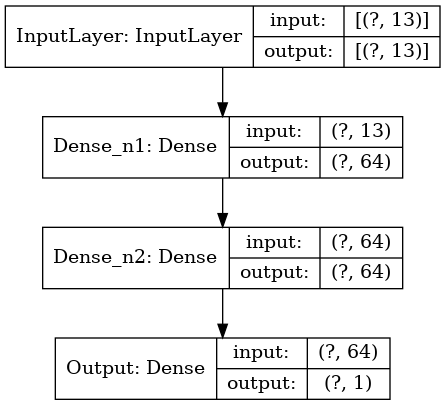

In [6]:
model=get_model_v1( (13,) )

model.summary()
keras.utils.plot_model( model, to_file='./run/model.png', show_shapes=True, show_layer_names=True, dpi=96)

### 5.2 - Add callback

In [7]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.h5"

savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 5.3 - Train it

In [8]:
history = model.fit(x_train,
                    y_train,
                    epochs          = 100,
                    batch_size      = 10,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks       = [savemodel_callback])

Train on 354 samples, validate on 152 samples
Epoch 1/100
354/354 [==============================] - 1s 2ms/sample - loss: 483.2389 - mae: 20.0008 - mse: 483.2388 - val_loss: 421.2562 - val_mae: 18.2848 - val_mse: 421.2561
Epoch 2/100
354/354 [==============================] - 0s 232us/sample - loss: 270.7346 - mae: 13.9655 - mse: 270.7346 - val_loss: 187.7437 - val_mae: 10.9696 - val_mse: 187.7437
Epoch 3/100
354/354 [==============================] - 0s 223us/sample - loss: 108.5703 - mae: 7.5648 - mse: 108.5703 - val_loss: 70.6387 - val_mae: 6.1047 - val_mse: 70.6387
Epoch 4/100
354/354 [==============================] - 0s 234us/sample - loss: 53.8803 - mae: 5.1135 - mse: 53.8803 - val_loss: 40.0765 - val_mae: 4.6628 - val_mse: 40.0765
Epoch 5/100
354/354 [==============================] - 0s 223us/sample - loss: 34.2413 - mae: 4.1321 - mse: 34.2413 - val_loss: 29.1298 - val_mae: 3.8690 - val_mse: 29.1298
Epoch 6/100
354/354 [==============================] - 0s 226us/sample - loss

## Step 6 - Evaluate
### 6.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  
A mae equal to 3 represents an average error in prediction of $3k.

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 12.2396
x_test / mae       : 2.6152
x_test / mse       : 12.2396


### 6.2 - Training history
What was the best result during our training ?

In [10]:
print("min( val_mae ) : {:.4f}".format( min(history.history["val_mae"]) ) )

min( val_mae ) : 2.1552


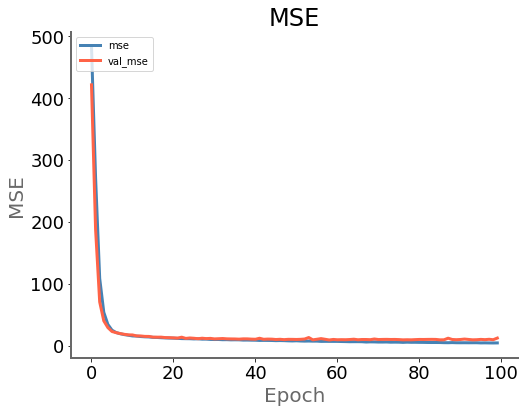

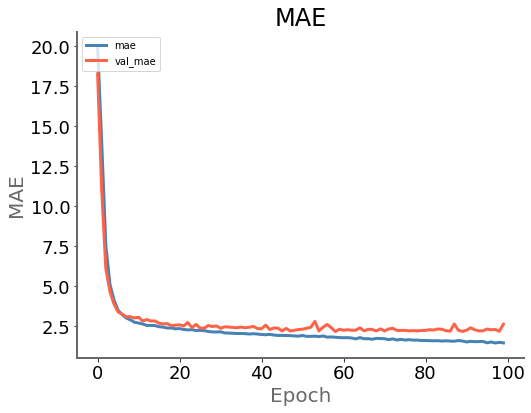

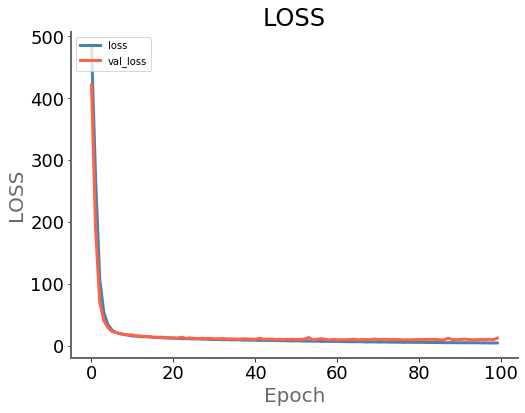

In [11]:
ooo.plot_history(history, plot={'MSE' :['mse', 'val_mse'],
                                'MAE' :['mae', 'val_mae'],
                                'LOSS':['loss','val_loss']})

## Step 7 - Restore a model :

### 7.1 - Reload model

In [12]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')
loaded_model.summary()
print("Loaded.")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_n1 (Dense)             (None, 64)                896       
_________________________________________________________________
Dense_n2 (Dense)             (None, 64)                4160      
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
Loaded.


### 7.2 - Evaluate it :

In [13]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 9.1795
x_test / mae       : 2.1552
x_test / mse       : 9.1795


### 7.3 - Make a prediction

In [14]:
mon_test=[-0.20113196, -0.48631663,  1.23572348, -0.26929877,  2.67879106,
       -0.89623587,  1.09961251, -1.05826704, -0.55823117, -0.06159088,
       -1.76085159, -1.97039608,  0.52775666]

mon_test=np.array(mon_test).reshape(1,13)

In [15]:
predictions = loaded_model.predict( mon_test )
print("Prédiction : {:.2f} K$   Reality : {:.2f} K$".format(predictions[0][0], y_train[13]))

Prédiction : 16.51 K$   Reality : 20.20 K$


---
![](../fidle/img/00-Fidle-logo-01_s.png)